In [32]:
import os
PATH_DATA = '../data'

PATH_DATA_RAW = os.path.join(PATH_DATA, 'raw')
FILENAME = "datasets.zip"

os.listdir(PATH_DATA_RAW)

['datasets.zip', '.DS_Store', '.gitkeep', 'datasets']

In [2]:
# import json

# with open(os.path.join(PATH, "read_errors.json"), "r") as handle:
#   read_errors = set(json.load(handle))

# with open(os.path.join(PATH, "not_enough_parts.json"), "r") as handle:
#   incomplete_songs = set(json.load(handle))

# skip = read_errors | incomplete_songs

# len(read_errors), len(incomplete_songs), len(skip)

FileNotFoundError: [Errno 2] No such file or directory: '../data/read_errors.json'

In [2]:
from zipfile import ZipFile

archive = ZipFile(os.path.join(PATH, FILENAME))

midi_paths = []
for path in archive.namelist():
    if path.endswith('.mid') and 'nokey' in path and path.startswith('datasets'):
        midi_paths.append(path)

len(midi_paths)

19876

In [3]:
import pandas as pd

catalog_df = pd.DataFrame.from_records(
    map(lambda x : x.split("/")[3:], midi_paths), 
    columns=["artist", "songname", "songpart"]
)
catalog_df["songpart"] = catalog_df["songpart"].apply(lambda x : x.split('.')[0].split('_')[0])
catalog_df

,artist,songname,songpart
0,rascal-flatts,what-hurts-the-most,verse
1,rascal-flatts,what-hurts-the-most,intro
2,rascal-flatts,what-hurts-the-most,chorus
3,rascal-flatts,bless-the-broken-road,verse
4,rascal-flatts,bless-the-broken-road,chorus
...,...,...,...
19871,working-for-a-nuclear-free-city,je-suis-le-vent,verse
19872,working-for-a-nuclear-free-city,je-suis-le-vent,instrumental
19873,wayne-wonder,no-letting-go,verse
19874,wayne-wonder,no-letting-go,bridge


In [4]:
len(catalog_df.artist.value_counts())

5107

In [5]:
# import matplotlib.font_manager
# [f.name for f in matplotlib.font_manager.fontManager.ttflist]

import matplotlib.pyplot as plt
from matplotlib import rcParams
# rcParams['font.family'] = 'Liberation Serif'

Text(0.5, 1.0, 'Top 30 artists')

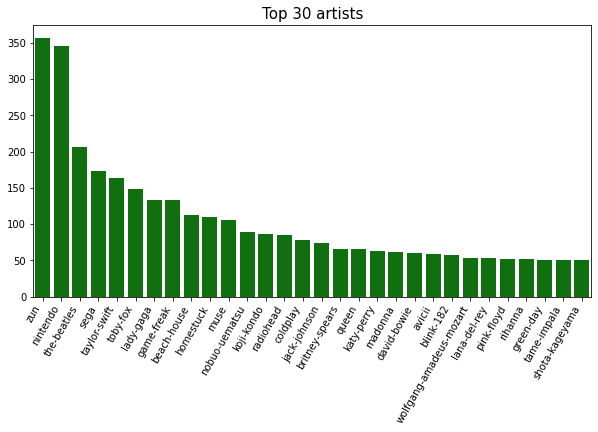

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

top_artists = catalog_df.artist.value_counts()[:30]
ax = sns.barplot(x=top_artists.index, y=top_artists.values, color="g")

_ = plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
)

plt.title("Top 30 artists", size=15)

Text(0.5, 1.0, 'Song parts')

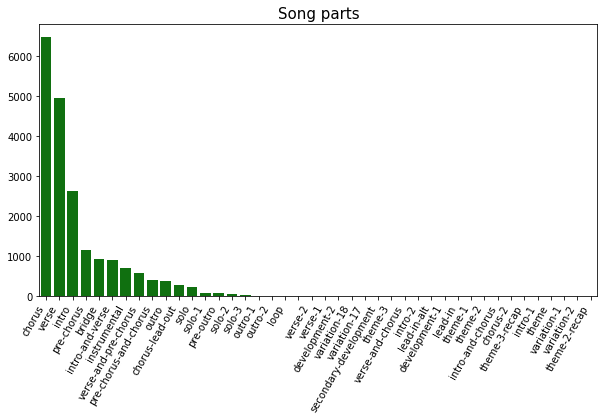

In [7]:
plt.figure(figsize=(10, 5))

top_songparts = catalog_df.songpart.value_counts()
ax = sns.barplot(x=top_songparts.index, y=top_songparts.values, color="g")

_ = plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
)
plt.title("Song parts", size=15)

In [8]:
import music21 as mc
import json

MODE_TO_OFFSET = {
    "1": 0,
    "2": 2, 
    "3": 4,
    "4": 5,
    "5": 7,
    "6": 9,
    "7": 11
}

def read_midi_from_archive(archive, path):
    mf = mc.midi.MidiFile()
    mf.readstr(archive.read(path))
    return mc.midi.translate.midiFileToStream(mf)

def read_mode(archive, midi_path):
    symbol_nokey_path = midi_path.replace('/pianoroll/', '/event/').replace('nokey.mid', 'symbol_nokey.json')
    read_data = archive.read(symbol_nokey_path)
    json_data = json.loads(read_data)
    return json_data.get("metadata", {}).get("mode", "?") 

def translate_to_c(sample, mode, debug=False):
    offset = MODE_TO_OFFSET.get(mode, -1)
    if offset > 0:
        if debug:
            print("Mode: ", mode)
        for part in sample.parts:
            part.transpose(offset, inPlace=True)
    return sample

In [9]:
path = midi_paths[0]
print(path)

sample = read_midi_from_archive(archive, path)
sample = translate_to_c(sample, read_mode(archive, path))

datasets/pianoroll/r/rascal-flatts/what-hurts-the-most/verse_nokey.mid


In [38]:
for element in sample.parts[0].flat:
    print(type(element))
    print('\t', element)
    if isinstance(element, mc.tempo.MetronomeMark):
        print(element.getQuarterBPM())
    if isinstance(element, mc.key.Key):
        pass
    if isinstance(element, mc.meter.TimeSignature):
        print(element.barDuration._getQuarterLength())
        print(element.displaySequence.__str__())

<class 'music21.instrument.Piano'>
	 Piano
<class 'music21.tempo.MetronomeMark'>
	 <music21.tempo.MetronomeMark Quarter=100.0>
100.0
<class 'music21.key.Key'>
	 A major
<class 'music21.meter.TimeSignature'>
	 <music21.meter.TimeSignature 4/4>
4.0
{4/4}
<class 'music21.note.Rest'>
	 <music21.note.Rest rest>
<class 'music21.note.Note'>
	 <music21.note.Note E>
<class 'music21.note.Note'>
	 <music21.note.Note F>
<class 'music21.note.Note'>
	 <music21.note.Note G>
<class 'music21.note.Note'>
	 <music21.note.Note G>
<class 'music21.note.Note'>
	 <music21.note.Note A>
<class 'music21.note.Note'>
	 <music21.note.Note C>
<class 'music21.note.Note'>
	 <music21.note.Note D>
<class 'music21.note.Note'>
	 <music21.note.Note E>
<class 'music21.note.Note'>
	 <music21.note.Note E>
<class 'music21.note.Rest'>
	 <music21.note.Rest rest>
<class 'music21.note.Note'>
	 <music21.note.Note A>
<class 'music21.note.Note'>
	 <music21.note.Note G>
<class 'music21.note.Note'>
	 <music21.note.Note F>
<class 'music

In [10]:
from collections import Counter

def estimate_part_type(part):
    types = [type(elem) for elem in part.notesAndRests]
    if mc.note.Note not in types:
        return "chords"
    else:
        counts = Counter(types)
    return "notes" if counts.get(mc.note.Note, 0) > counts.get(mc.chord.Chord, 0) else "chords"

def _estimate_single_part_type(part):
#     if part.voices:
#         return "voices"
    counts = Counter([type(elem) for elem in part.flat])
    if counts.get(mc.note.Note, 0) > counts.get(mc.chord.Chord, 0):
        return "notes"
    elif counts.get(mc.note.Note, 0) < counts.get(mc.chord.Chord, 0):
        return "chords"
    return "?"
      
def estimate_parts_types_OLD(part1, part2):
    """
    LOGIC:
    1. For each part separately, if it has more notes than chords, then it's notes. If it has more chords than notes, then it's chords.
    If the number of notes and chords is equal, keep it as undefined.
    2. Check for duplicate part types, 2x. notes or 2x. chords.
    Raise exception if both were undefined (same count of notes and chords in both parts)
    Otherwise, compare counts of chords between parts. Assign 'chords' type to the one which has more chords and 'notes' to the other one.
    If counts of chords were equal, then compare lengths of parts. The shorter one will be assigned to 'chords' and longer one to 'notes'. 
    If there was no match - lenghts are also equal, then raise exception. (? will this line of code execute ?)
    3. If there were no duplicate part types, and there is 'undefined' mark left, then fill it with the remaining type.
    4. At the end, two types should be different and defined. (assert)
    """
    t1, t2 = "?", "?"
  
    t1 = _estimate_single_part_type(part1)
    t2 = _estimate_single_part_type(part2)

    if t1 == t2:    
        counts1 = Counter([type(elem) for elem in part1.notes])
        counts2 = Counter([type(elem) for elem in part2.notes])
        if t1 == "?":
            raise Exception("Counts of Notes and Chords are equal in both parts!")
        else:
            if counts1.get(mc.chord.Chord, 0) > counts2.get(mc.chord.Chord, 0):
                t1, t2 = "chords", "notes"
            elif counts1.get(mc.chord.Chord, 0) < counts2.get(mc.chord.Chord, 0):
                t1, t2 = "notes", "chords"
            else:
                if len(part1.notes) < len(part2.notes):
                    t1, t2 = "chords", "notes"
                elif len(part1.notes) < len(part2.notes):
                    t1, t2 = "notes", "chords"
                else:
                    raise Exception("NO WAY I CAN'T IDENTIFY THOSE PARTS")
    elif t1 == "?":
            t1 = "notes" if t2 == "chords" else "chords"
    elif t2 == "?":
        t2 = "notes" if t1 == "chords" else "chords"
  
    assert t1 != "?" != t2
    return t1, t2

def estimate_parts_types(part1, part2):
    t1 = _estimate_single_part_type(part1)
    t2 = _estimate_single_part_type(part2)
    if t1 == t2:
        print(f"Same types: {t1} and {t2}")
        return None, None
    else:
        return t1, t2
    
def extract_parts_types(sample):
    if not sample.parts or len(sample.parts) > 2:
        return (None, None)
    elif len(sample.parts) == 1:
        return (_estimate_single_part_type(sample.parts[0]),)
    else:
        t1 = _estimate_single_part_type(sample.parts[0])
        t2 = _estimate_single_part_type(sample.parts[1])
        if t1 == t2:
            print(f"Same types: {t1} and {t2}")
            return (None, None)
        else:
            return (t1, t2)

In [11]:
path = midi_paths[36]
sample = read_midi_from_archive(archive, path)
sample = translate_to_c(sample, read_mode(archive, path))
x, y = extract_parts_types(sample)

In [12]:
for t, part in zip((x, y), sample.parts):
    print(t, list(part.voices))

notes [<music21.stream.Voice 0x15d91a550>, <music21.stream.Voice 0x15d91a610>]
chords []


In [13]:
for voic in sample.parts[0].voices:
    print(list(voic.notes))

[<music21.note.Note A>, <music21.note.Note G>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note F>, <music21.note.Note E>, <music21.note.Note C>, <music21.note.Note A>, <music21.note.Note G>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note F>, <music21.note.Note E>, <music21.note.Note C>, <music21.note.Note E>, <music21.note.Note C>, <music21.note.Note A>, <music21.note.Note G>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note F>, <music21.note.Note E>, <music21.note.Note C>, <music21.note.Note C>, <music21.note.Note C>, <music21.note.Note A>, <music21.note.Note A>, <music21.note.Note G>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>, <music21.note.Note F>, <music21.note.Note E>, <music21.note.Note C>, <music21.note.Note E>, <music21.note.Note C>]
[<music21.note.Note G>, <music21.note.Note A>, <music21.note.Note C>, <music21.

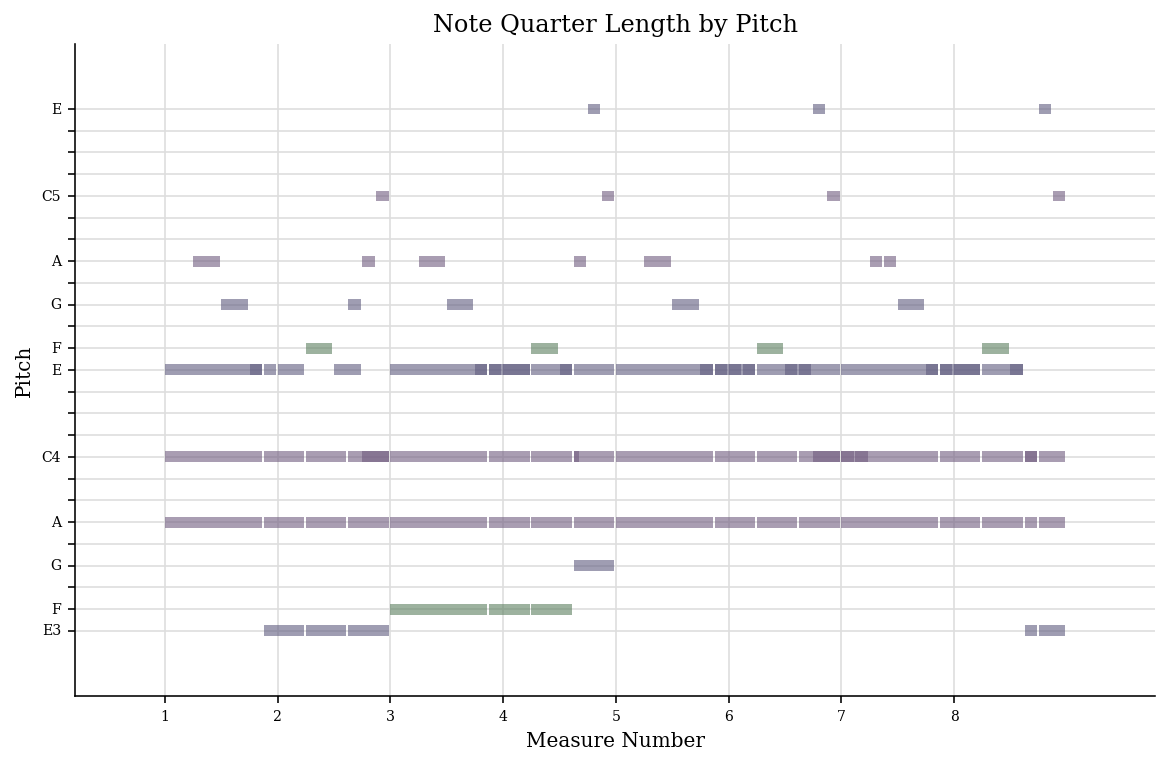

In [14]:
sample.measures(0, 20).plot()

In [15]:
count_OK = 0
count_wrong = 0
paths_OK = []

for idx, path in enumerate(midi_paths):
#     try:
    sample = read_midi_from_archive(archive, path)
    sample = translate_to_c(sample, read_mode(archive, path))
    parts_types = extract_parts_types(sample)
    if not parts_types:
        count_wrong += 1
    else:
        count_OK += 1
        paths_OK.append(path)

#     except Exception as ex:
#     count_wrong += 1
#     print(ex)
    if idx % 1000 == 0:
        print(idx)
        
print(count_OK, count_OK/len(midi_paths) * 100.0)
print(count_wrong, count_wrong/len(midi_paths) * 100.0)

0
1000
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
2000
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
3000
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and 

In [16]:
def extract_as_notes(part):
    names, durations = [], []
    if part.notesAndRests:
        notes_and_rests = part.notesAndRests
    elif part.voices:
        select_voice = part.voices[np.argmax(len(voice) for voice in part.voices)]
        assert _get_most_common(select_voice)[0][0] == mc.note.Note
        notes_and_rests = select_voice.notesAndRests
    else:
        return names, durations
    
    for nt in notes_and_rests:
        if isinstance(nt, mc.note.Note):
            names.append(nt.pitch.nameWithOctave)
        elif isinstance(nt, mc.note.Rest):
            names.append("REST")
        elif isinstance(nt, mc.chord.Chord):
            # Take only first note
            first = nt.pitches[0]
            names.append(first.nameWithOctave)
        else:
            raise Exception(f"Unknown note type: {type(nt)} ???")
        durations.append(nt.quarterLength)
    return names, durations

def extract_as_chords(part, octave_invariant=False):
    names, durations = [], []
    if part.notesAndRests:
        notes_and_rests = part.notesAndRests
    elif part.voices:
        select_voice = part.voices[np.argmax(len(voice) for voice in part.voices)]
        assert _get_most_common(select_voice)[0][0] == mc.chord.Chord
        notes_and_rests = select_voice.notesAndRests
    else:
        return names, durations
    
    for nt in notes_and_rests:
        if isinstance(nt, mc.note.Note):
            names.append([nt.pitch.name if octave_invariant else nt.pitch.nameWithOctave])
        elif isinstance(nt, mc.note.Rest):
            names.append(["REST"])
        elif isinstance(nt, mc.chord.Chord):
            ps_sorted = sorted(nt.pitches, key=lambda pitch: pitch.ps)
            names.append([
                pitch.name if octave_invariant else pitch.nameWithOctave 
                for pitch in ps_sorted
            ])
            """
            if octave_invariant:
                pitch_names = [pitch.name for pitch in ps_sorted]
                pitch_names = sorted(pitch_names, key=lambda p_name: mc.note.Note(p_name).pitch.ps)
                names.append(pitch_names)
            else:
                names.append([pitch.nameWithOctave for pitch in ps_sorted])
            """
        else:
            raise Exception(f"Unknown note type: {type(nt)} ???")
        durations.append(nt.quarterLength)
    return names, durations

def _get_most_common(part):
    if len(part.notesAndRests) == 0:
        return None
    else:
        types = list(map(type, part.notesAndRests))
        return Counter(types).most_common()

def extract_music(midi_sample, chords_octave_invariant=True):
    result = {}
    if len(midi_sample.parts) > 2:
        raise Exception(f"Midi sample given has more than TWO parts ({len(midi_sample.parts)})")
        
    part_types = extract_parts_types(sample)

    for part_type, part in zip(part_types, midi_sample.parts):
        names, durations = None, None
        if part_type == "notes":
            names, durations = extract_as_notes(part)
        elif part_type == "chords":
            names, durations = extract_as_chords(part, octave_invariant=chords_octave_invariant)
            
#     elif part_type == "voices":
#       longest_voice = -1
#       for xx, voicepart in enumerate(part.voices):
#         most_common = _get_most_common(voicepart)
#         types = list(map(lambda x : x[0], most_common))
#         # if mc.chord.Chord not in map(lambda x : x[0], most_common):
#         if types and types[0] == mc.note.Note:
#           tmp_pitches, tmp_names, tmp_durations = extract_as_notes(voicepart)
#           if len(tmp_pitches) > longest_voice:
#             pitches, names, durations = tmp_pitches, tmp_names, tmp_durations
#             longest_voice = len(pitches)
#             part_type = "notes"
    
        if names and durations:
            result[part_type] = {
                "names": names,
                "durations": durations
            }

    return result

Some songs don't have the melody! We can keep them as test set. :)

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


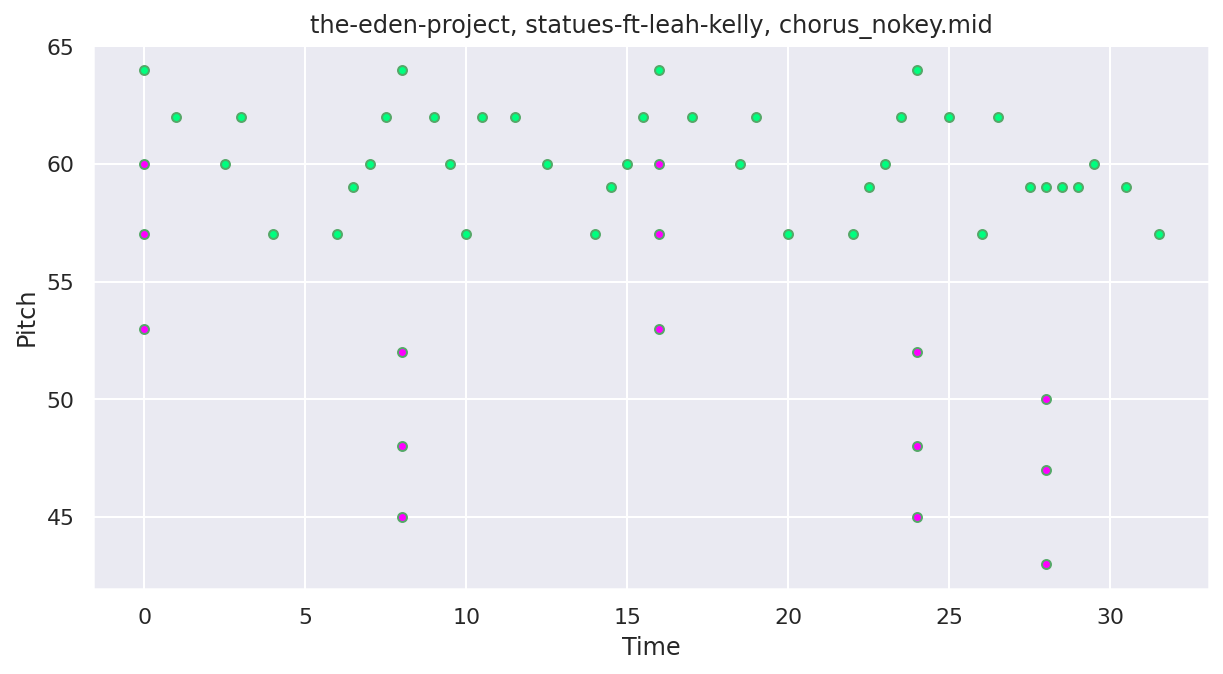

In [32]:
import matplotlib.lines as mlines

def show_song(sample, title=None):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1)
  
  for part in sample.parts:
    x = []
    y = []
    if isinstance(part.notes[0], mc.chord.Chord):
      c = "magenta"
      for ch in part.notes:
        for pitch in ch.pitches:
          x.append(ch.offset)
          y.append(pitch.ps)
    elif isinstance(part.notes[0], mc.note.Note):
      c = "springgreen"
      for nt in part.notes:
          x.append(nt.offset)
          y.append(nt.pitch.ps)

    ax.scatter(x, y, alpha=1.0, s=20, color=c, edgecolor='g')

  if title:
    plt.title(title)

  plt.xlabel("Time")
  plt.ylabel("Pitch")
  plt.show()

for idx in [5238]:
  path = midi_paths[idx]
  sample = read_midi_from_archive(archive, path)
  sample = translate_to_c(sample, read_mode(archive, path))
  show_song(sample, title=", ".join(path.split('/')[3:]))

In [18]:
sample.parts[0]

<music21.stream.Part 0x15edc1af0>

In [20]:
import numpy as np

path = midi_paths[36]
print(path)

sample = read_midi_from_archive(archive, path)
sample = translate_to_c(sample, read_mode(archive, path))
music = extract_music(sample, chords_octave_invariant=True)

def transform_notes_to_tokens(music):
    return list(
        map(
            lambda x : f"{x[0]}_{str(x[1])}", zip(
                music["notes"]["names"], 
                music["notes"]["durations"]
            )
        )
    ) if "notes" in music else []

def transform_chords_to_tokens(music):
    return list(
        map(
            lambda x : f"{'.'.join(x[0])}_{str(x[1])}", zip(
                music["chords"]["names"], 
                music["chords"]["durations"]
            )
        )
    ) if "chords" in music else []

transform_notes_to_tokens(music)[:10], transform_chords_to_tokens(music)[:5]

datasets/pianoroll/r/rae-sremmurd/black-beatles/chorus_nokey.mid


(['REST_1.0',
  'A4_1.0',
  'G4_1.0',
  'E4_0.5',
  'E4_0.5',
  'E4_1.0',
  'F4_1.0',
  'E4_1.0',
  'C4_1.0',
  'REST_1.0'],
 ['A.C.E_3.5', 'E.A.C_1.5', 'E.A.C_1.5', 'E.A.C_1.5', 'F.A.C.E_3.5'])

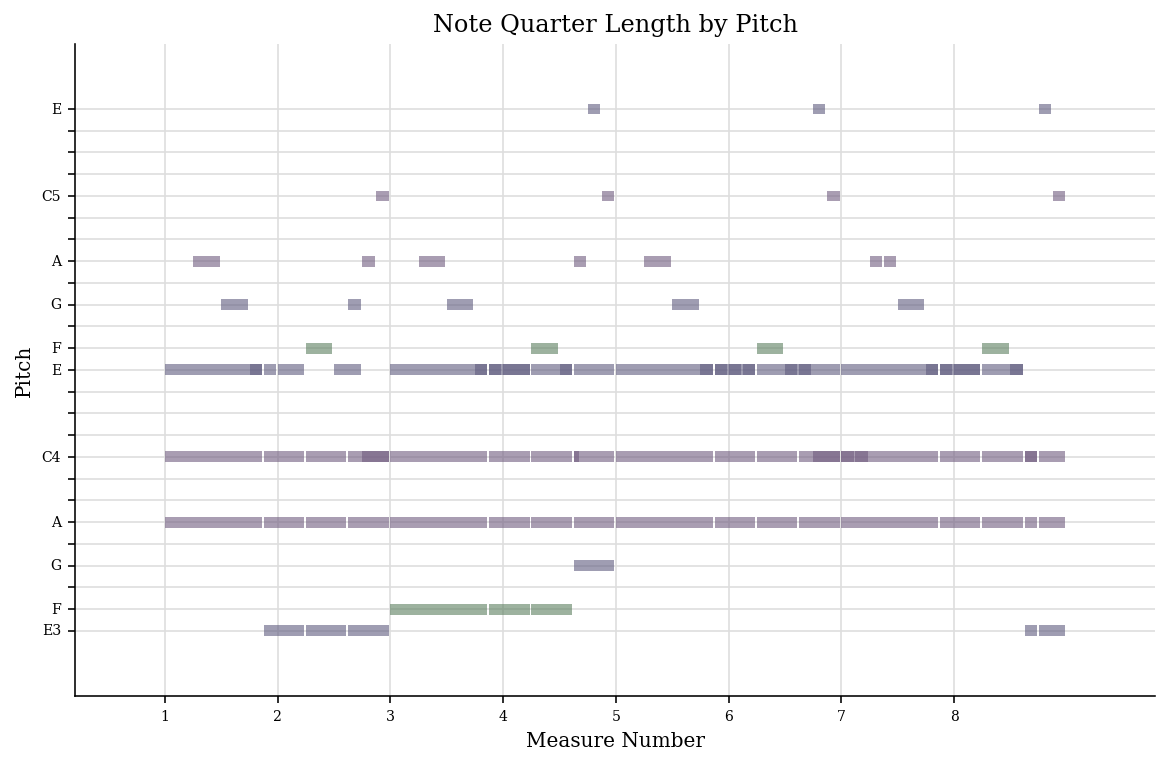

In [21]:
sample.measures(0, 10).plot()

In [25]:
notes = []
chords = []

parse_success = []
parse_failures = []

modes = []

for idx, path in enumerate(midi_paths):
    sample = read_midi_from_archive(archive, path)
    mode = read_mode(archive, path)
    modes.append(mode)
    sample = translate_to_c(sample, mode)
    try:
        music = extract_music(sample, chords_octave_invariant=True)
        notes.append(transform_notes_to_tokens(music))
        chords.append(transform_chords_to_tokens(music))
        parse_success.append(path)
    except Exception as e:
        parse_failures.append(path)
        print(path.replace('datasets/pianoroll/', ''), e)
        continue

    if idx % 100 == 0:
        print(idx)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
1400
1500
Same types: chords and chords
1600
1700
1800
Same types: chords and chords
1900
n/naoki-kodaka/nes-batman---stage-4---laboratory-ruins/intro_nokey.mid 
2000
Same types: chords and chords
2100
Same types: chords and chords
2200
Same types: chords and chords
2300
Same types: chords and chords
Same types: chords and chords
2400
2500
g/game-freak/vs-frontier-brain---sinnoh/verse_nokey.mid 
Same types: chords and chords
2600
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
2700
2800
Same types: chords and chords
2900
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
3000
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
Same types: chords and chords
3100
Sam

In [26]:
len(notes), len(chords)

(19866, 19866)

In [27]:
len(parse_success), len(parse_failures), len(midi_paths)

(19866, 10, 19876)

In [30]:
chords[0]

['A.C.E.G_4.0',
 'G.B.D.A_4.0',
 'F.A.C.G_8.0',
 'A.C.E.G_4.0',
 'G.B.D.A_4.0',
 'F.A.C.G_8.0',
 'A.C.E.G_4.0',
 'G.B.D.A_4.0',
 'F.A.C.G_8.0',
 'A.C.E.G_4.0',
 'G.B.D.A_4.0',
 'F.A.C.G_8.0']

Text(0.5, 1.0, 'Distribution of song modes')

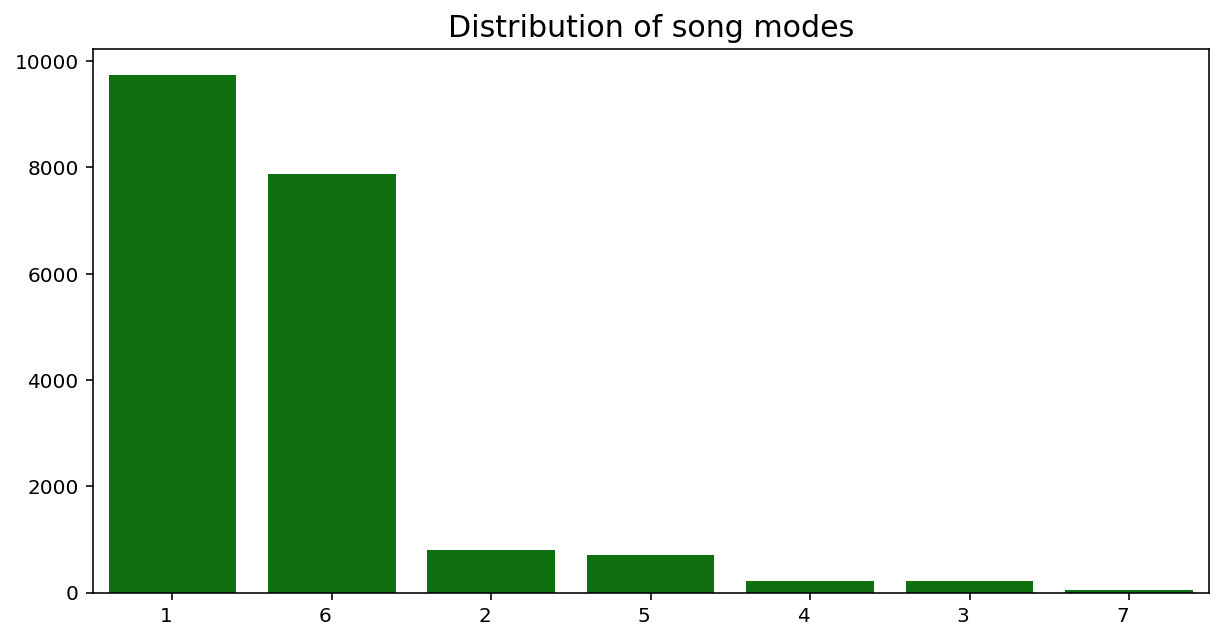

In [28]:
plt.figure(figsize=(10, 5))

modes_df = pd.DataFrame({"song_mode": modes})
top_modes = modes_df.song_mode.value_counts()
ax = sns.barplot(x=top_modes.index, y=top_modes.values, color="g")

_ = plt.xticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
)
plt.title("Distribution of song modes", size=15)

## FIX CHORDS

In [29]:
def _sum_chords_duration(chords):
    return sum(float(ch.split('_')[1]) for ch in chords)

def _compare_chords(old, new):
    old_filtered = [ch for ch in old if "R" not in ch]
    for o, n in zip(old_filtered, new):
        assert o.split("_")[0] == n.split("_")[0]

        
def fix_chords(chords):

    fixed_chords = []

    for idx, chs in enumerate(chords):
        new_chs = []
        ch_idx = 0
        
        prev_chord, prev_duration = None, 0.0
        while ch_idx < len(chs):
            ch = chs[ch_idx]
            current_chord, current_duration = ch.split('_')
            current_duration = float(current_duration)
            if current_chord == "REST":
                prev_duration += current_duration
            else:
                if prev_chord:
                    new_chs.append(f"{prev_chord}_{str(prev_duration)}")
                    prev_chord, prev_duration = current_chord, current_duration
                else:
                    prev_chord = current_chord
                    prev_duration += current_duration

            ch_idx += 1

        new_chs.append(f"{prev_chord}_{str(prev_duration)}")
        s1, s2 = _sum_chords_duration(chs), _sum_chords_duration(new_chs)
        assert s1 == s2
        _compare_chords(chs, new_chs)
        fixed_chords.append(new_chs)
        
    return fixed_chords

In [33]:
PATH_DATA_RAW

'../data/raw'

In [34]:
parsed_dict = {
    "notes": notes,
    "chords": fix_chords(chords),
    "parse_success": parse_success,
    "parse_failures": parse_failures
}
parsed_dict["info"] = "New parsed data. Chords are OCTAVE-INVARIANT. There are NO RESTS in CHORDS!"

import json

PATH_DATA_INTERIM = os.path.join(PATH_DATA, 'interim')

with open(os.path.join(PATH_DATA_INTERIM, "parsed.json"), "w") as handle:
    json.dump(parsed_dict, handle)

In [35]:
! ls {PATH_DATA_INTERIM}

parsed.json


In [37]:
c = Counter([ch.split('_')[0] for chords in parsed_dict["chords"] for ch in chords])
print(len(c))
c.most_common()

649


[('A.C.E', 43296),
 ('C.E.G', 42150),
 ('G.B.D', 39870),
 ('F.A.C', 39811),
 ('D.F.A', 14804),
 ('E.G.B', 10314),
 ('F.A.C.E', 6716),
 ('A.C.E.G', 6157),
 ('D.F.A.C', 6010),
 ('E.G#.B', 5364),
 ('E.G.C', 3952),
 ('E.G.B.D', 3948),
 ('B-.D.F', 3852),
 ('B.D.G', 3349),
 ('D.F#.A', 3249),
 ('G.B.D.F', 3089),
 ('G.C.E', 2943),
 ('C.E.G.B', 2561),
 ('A.C#.E', 2475),
 ('E.G#.B.D', 2122),
 ('G.C.D', 2024),
 ('C.E.A', 2004),
 ('E.A.C', 1999),
 ('C.F.A', 1904),
 ('F.A.C.G', 1798),
 ('D.G.B', 1647),
 ('A.C.F', 1630),
 ('E-.G.B-', 1408),
 ('G#.C.E-', 1342),
 ('F.A.D', 1234),
 ('G.B.E', 1105),
 ('G.A.C.E', 1089),
 ('G#.B.E', 1001),
 ('F.G.C', 984),
 ('F.G#.C', 933),
 ('F.A.C.D', 923),
 ('G.B.D.E', 854),
 ('C.E.G.D', 845),
 ('B.D.F', 844),
 ('D.F#.A.C', 829),
 ('A.C#.E.G', 819),
 ('B.E.G', 817),
 ('G#.B.D', 813),
 ('C.E.G.B-', 783),
 ('G.B.D.A', 773),
 ('B.E-.F#', 768),
 ('A.D.F', 746),
 ('G.B-.D', 731),
 ('A.D.E', 726),
 ('G.C.D.F', 724),
 ('C.F.G', 709),
 ('B.D.F#', 700),
 ('C.E.G.A', 678),
 ('F.